Generate Figure 3-a of the original manuscript (PEL-Potential Energy Landscape)
>> 12-order QAOA-Williamson

In [1]:
!pip install qiskit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 3.9 MB/s eta 0:00:00


In [2]:
!pip install qiskit-aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 75.2 MB/s eta 0:00:00


In [3]:
!pip install sympy

*** FUNCTIONs DEFINITION

In [4]:
#*** Functions Definitions ***
#import matplotlib.pyplot as plt
#-----------------------------------------------
# solve williamson hadamard problem, 8-unknown variables
# ---
# H= 4+ 2*s0*s1 + 2*s2*s3 + 2*s4*s5 + 2*s6*s7
#   s0*s1*s2*s3 + s0*s1*s4*s5 + s0*s1*s6*s7 + s2*s3*s4*s5 + s2*s3*s6*s7 + s4*s5*s6*s7
#-----------------------------------------------
#-- MIXING UNITARY
#from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
#from qiskit import Aer, execute
from qiskit_aer import Aer
#from qiskit import execute
from qiskit.circuit import Parameter
from scipy.optimize import minimize
from qiskit.visualization import plot_histogram

#//////////////////////////////////////////////////
# // import from propietary library from PRB folder
# // copy them here
#//////////////////////////////////////////////////

GSOL=''

# convert binary {0,1} -> spin {-1, +1}
def b2s(x):
    if (x<1):
        s= 1.0
    if (x>0):
        s= -1.0
    return s

##
def obj_si(tv, Es):
    # evaluate objective function for a string tv
    # Es=sympify(E12)
    #
    NQ=len(tv)
    ss=symbols('s0:%d'%NQ)
    #
    for n in range(0,NQ):
        Es=Es.subs(ss[n],tv[n])
    # --
    obj=Es.evalf()
    return obj
##////
def obj_si_vspin(vs, Es):
    # evaluate objective function for a string tv
    # Es=sympify(E12)
    N=len(vs)
    tv=[]
    for n in range(0,N):
        tv.append(b2s(int(vs[n])))
    #---
    obj=obj_si(tv, Es)
    #
    return obj
#--
def hadamard_obj(vs, Es):
    # value of objective function
    # TO BE MODIFIED WITH HADAMARD MATRIX
    ##############################################
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.

    Args:
        x: str
           solution bitstring
    Returns:
        obj: float
             Objective
    """
    #---
    N=len(vs)
    tv=[]
    for n in range(0,N):
        tv.append(b2s(int(vs[n])))
    #---
    #obj=obj_si(tv, Es)
    #/////////////////////////////////
    #/////////////////////////////////
    obj=obj_williamson_12(vs)
    #/////////////////////////////////
    #/////////////////////////////////
    #
    #print('obj->', obj, vs)

    SOL=''
    F_Found=0
    if abs(obj)<0.00001:
        SOL=vs
        F_Found=1
        GEN_SOL.append(vs)
        #print('Solution Found ...!', obj, SOL)
    return obj, F_Found #, SOL


def compute_expectation(counts):

    """
    Computes expectation value based on measurement results
    Args:
        counts: dict
                key as bitstring, val as count
    Returns:
        avg: float
             expectation value
    """

    avg = 0
    sum_count = 0
    cnt_corr_sol=0

    for bitstring, count in counts.items():

        #obj, SOL = hadamard_obj(bitstring)
        obj, F_Found = hadamard_obj(bitstring, Es)
        if F_Found>0:
            cnt_corr_sol=cnt_corr_sol+count
            #print('Correct Sol->', count)
        avg += obj * count
        sum_count += count
    #---
    vShots.append(sum_count)
    vCorrect.append(cnt_corr_sol)
    #---
    return avg/sum_count



# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(p, shots=1*512):

    """
    Runs parametrized circuit

    Args:
        p: int,
           Number of repetitions of unitaries
    """

    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots

    def execute_circ(theta):

        qc=create_qaoa_circ_from_terms(qx,nqubits,theta)
        #--
        #print(qc.draw())
        # --
        counts = backend.run(qc, seed_simulator=10,
                             nshots=1*512).result().get_counts()
        #return compute_expectation(counts)
        mean_obj=compute_expectation(counts)
        vObj.append(mean_obj)
        #return compute_expectation(counts)
        return mean_obj

    return execute_circ
#

def read_H_fromfile(fname):
    with open(fname) as f:
        lines = f.readlines()
    #
    return(lines[0])
#
def most_frequent_one(vcnt):
        """
        Return the most frequent count
        only one string of most freq --> mod by suksmono@STEI
        """
        max_value = max(vcnt.values())
        max_values_counts = [x[0] for x in vcnt.items() if x[1] == max_value]
        return max_values_counts[0]
# --
#
def most_frequent_list(vcnt):
        """
        Return the most frequent count
        only one string of most freq --> mod by suksmono@STEI
        """
        max_value = max(vcnt.values())
        max_values_counts = [x[0] for x in vcnt.items() if x[1] == max_value]
        return max_values_counts #[0]
# --

In [5]:
##prb_h2qcircuit
###############################
# -*- coding: utf-8 -*-
"""
Created on Sat Mar 26 02:51:18 2022
# module
# convert hamiltonian to quantum circuit
@author: quanta
"""
from qiskit import QuantumCircuit
#, ClassicalRegister, QuantumRegister

#////////////////////////////////////
# -- 1-body --
def U_C_1body(qc, c, gamma, qbs):
    # ---[ 2*C*gamma] --->
    # konstanta c, taruh dimana?
    qc.rz(2*c*gamma, qbs)
#
# -- 2-body --
def U_C_2body(qc, c, gamma, qbs):
    qc.cx(qbs[0], qbs[1])
    qc.rz(2*c*gamma, qbs[1])
    qc.cx(qbs[0], qbs[1])
    # no return, assume qml global

# -- 3-body --
def U_C_3body(qc, c, gamma, qbs):
    qc.cx(qbs[0], qbs[1])
    qc.cx(qbs[1], qbs[2])
    #
    qc.rz(2*c*gamma, qbs[2])
    #
    qc.cx(qbs[1], qbs[2])
    qc.cx(qbs[0], qbs[1])

# -- 4-body --
def U_C_4body(qc, c, gamma, qbs):
    qc.cx(qbs[0], qbs[1])
    qc.cx(qbs[1], qbs[2])
    qc.cx(qbs[2], qbs[3])
    #
    qc.rz(2*c*gamma, qbs[3])
    #
    qc.cx(qbs[2], qbs[3])
    qc.cx(qbs[1], qbs[2])
    qc.cx(qbs[0], qbs[1])

#--
###
def term_2_qidx(term):
    # ---------------------------------------------------------
    # convert energy/hamiltonian terms into coefficient and
    # indices of qubit
    # --- qubit ordering may not follow the terms: ??
    # input: term (symbolic)
    # output: [coeff, [qidx0, qidx1, ...]]
    # ---------------------------------------------------------
    coeff=1.0
    #split term into atoms
    atm=term.atoms()
    N=len(atm)
    qlist=list()
    for n in range (0,N):
        ts=atm.pop()
        if ts.is_number:
            coeff=float(ts)
        else:
            ss=str(ts)
            qidx=int(ss[1:])
            qlist.append(qidx)
    return [coeff, qlist]

def efunct_2_qidx(Esym):
    #
    #
    Eterms=Esym.args
    # number of term
    N=len(Eterms)
    qxlist=list()
    for n in range(0,N):
        tterm=Eterms[n]
        qidx=term_2_qidx(tterm)
        #print(n,'>',tterm,'>>',qidx )
        qxlist.append(qidx)
    return(qxlist)
#

#--
def create_qaoa_circ_from_terms(qx, n_qubits, theta):
    """
    Creates a parametrized qaoa circuit
    Args:
        theta: list
               unitary parameters
    Returns:
        qc: qiskit circuit
    """

    nqubits = n_qubits # len(G.nodes())
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    #--
    beta = theta[:p]
    gamma = theta[p:]

    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    ##--
    for irep in range(0, p):
        for n in range(0,len(qx)):
            tqx=qx[n]
            #print(n,'>>',qx[n] )
            if len(tqx[1])==1:
                # 1-body
                #print('1-body>', tqx)
                #if len(tqx[1])>0:
                U_C_1body(qc, tqx[0], gamma[irep], tqx[1])
            #
            else:
                if len(tqx[1])==2:
                    #2-body
                    #print('2-body>', tqx)
                    U_C_2body(qc, tqx[0], gamma[irep], tqx[1])
                #
                else:
                    if len(tqx[1])==3:
                        #3-body
                        #print('3-body>', tqx)
                        U_C_3body(qc, tqx[0], gamma[irep], tqx[1])
                    else:
                        if len(tqx[1])==4:
                            #4-body
                            #print('4-body>', tqx)
                            U_C_4body(qc, tqx[0], gamma[irep], tqx[1])
        # mixer unitary
        qc.barrier()
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)
    #--
    #print(qc.draw())
    qc.measure_all()
    return qc
#////////////////////////////////////



In [6]:
### OBJECTIVE FUNCTION// part of prb_objwilliamson.py
#////////////////////////////////////////////////////
# order: 12
#////////////////////////////////////////////////////
def obj_williamson_12(tv):
    #---------------
    # 12-order williamson
    # calculate the value of objective function
    # i.e. Hamiltonian's energy of a solution/bitstring
    # ---
    # /////////// harusnya konversi [0,1] -> [-1, +1] ...??????
    ## >> revised
    # NQUBITS=8
    s0=b2s(int(tv[0]))
    s1=b2s(int(tv[1]))
    s2=b2s(int(tv[2]))
    s3=b2s(int(tv[3]))
    s4=b2s(int(tv[4]))
    s5=b2s(int(tv[5]))
    s6=b2s(int(tv[6]))
    s7=b2s(int(tv[7]))
    ############################################################################
    ## /////// for obj to be valid, do not forget "(" and ")" //////////////////
    ############################################################################
    obj =  (s0*s1*s2*s3 + s0*s1*s4*s5 + s0*s1*s6*s7 + 2*s0*s1 + s2*s3*s4*s5
            + s2*s3*s6*s7 + 2*s2*s3 + s4*s5*s6*s7 + 2*s4*s5 + 2*s6*s7 + 4)
    #/////////////////////////////////////////////////////
    # obj=abs(obj) ## since we seek for zero as a minimum
    return obj
#////////////////////////////////////////////////////


*** MAIN ***

Streaming output truncated to the last 5000 lines.
[ 50 , 1 ] >> 3.951171875
[ 50 , 2 ] >> 3.951171875
[ 50 , 3 ] >> 3.951171875
[ 50 , 4 ] >> 3.951171875
[ 50 , 5 ] >> 3.951171875
[ 50 , 6 ] >> 3.951171875
[ 50 , 7 ] >> 3.951171875
[ 50 , 8 ] >> 3.951171875
[ 50 , 9 ] >> 3.951171875
[ 50 , 10 ] >> 3.951171875
[ 50 , 11 ] >> 3.951171875
[ 50 , 12 ] >> 3.951171875
[ 50 , 13 ] >> 3.951171875
[ 50 , 14 ] >> 3.951171875
[ 50 , 15 ] >> 3.951171875
[ 50 , 16 ] >> 3.951171875
[ 50 , 17 ] >> 3.951171875
[ 50 , 18 ] >> 3.951171875
[ 50 , 19 ] >> 3.951171875
[ 50 , 20 ] >> 3.951171875
[ 50 , 21 ] >> 3.951171875
[ 50 , 22 ] >> 3.951171875
[ 50 , 23 ] >> 3.951171875
[ 50 , 24 ] >> 3.951171875
[ 50 , 25 ] >> 3.951171875
[ 50 , 26 ] >> 3.951171875
[ 50 , 27 ] >> 3.951171875
[ 50 , 28 ] >> 3.951171875
[ 50 , 29 ] >> 3.951171875
[ 50 , 30 ] >> 3.951171875
[ 50 , 31 ] >> 3.951171875
[ 50 , 32 ] >> 3.951171875
[ 50 , 33 ] >> 3.951171875
[ 50 , 34 ] >> 3.951171875
[ 50 , 35 ] >> 3.951171875
[ 50 , 36 ] >

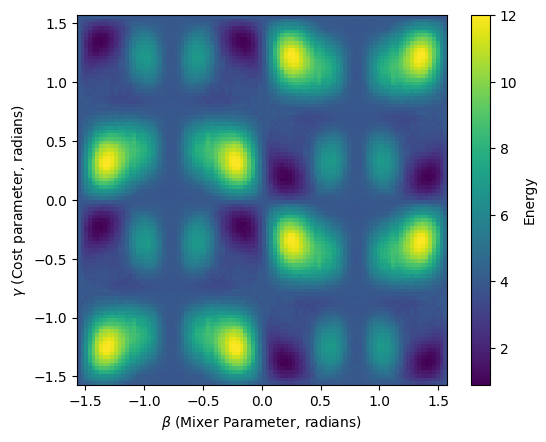

In [8]:
##########################################################################
# MAIN START
# (1) read hamiltonian Htxt from text file
# (2) convert Htxt to symbolic by sympify -> Es
# (3) find minimum energy of Es, check if H-matrix is found
##########################################################################
## FIG.3.(a) hanya perlu E12
E12 = '4+ 2*s0*s1 + 2*s2*s3 + 2*s4*s5 + 2*s6*s7 + s0*s1*s2*s3 + s0*s1*s4*s5 + s0*s1*s6*s7 + s2*s3*s4*s5 + s2*s3*s6*s7 + s4*s5*s6*s7'
##-- possible read directly to text file
import random
from collections import Counter
import matplotlib.pyplot as plt
##-- additional
from sympy import sympify
import numpy as np

# define some global variables
# //////////////////////////////
vObj=[]
vShots=[]
vCorrect=[]
GEN_SOL=[]
if __name__ == '__main__':
    #/////////////////////////////////
    # read hamiltonians from a file
    #/////////////////////////////////
    fpath='../hamiltonians-williamson/'
    #
    K = 3# 3 #5# 5#3 #5
    M= 4*K # order of H-matrix
    #
    print('Hadamard matrix of Williamson type, order:', M)
    #Etxt=htxt
    Etxt=E12
    # --------------------------
    # number of required qubits
    # --------------------------
    K05=int(K/2)+1 # 3: 0,1,1,0-> {0,1}, 5: 0,1,2,2,1-> {0,1,2}
    NQ0=4*K05 # no.of main qubits
    #///////
    # NQ=4*((K/2)+1) =2K+4
    # M = 4K => K=M/4
    #//// NQ=2(M/4) + 4 = (M/2)+4 ???
    #//////////////////////////////////////
    nqubits = NQ0 #3-body case
    NQ=NQ0
    #////////////////////////////
    # convert to symbols
    #////////////////////////////
    #Es=sympify(E12) # E12, E20, ...
    Es=sympify(Etxt) # E12, E20, ...


    qx=efunct_2_qidx(Es)
    #/// DEBUG
    # list all terms
    '''
    for n in range(0,len(qx)):
        print(n,'>>',qx[n] )
    '''
    ###############################
    # //// remark/remove seed for repeated experiments
    RSEED=2 #2,3,5,7,11,13,17,19,23,29>>NQ
    # //////////////////////////////////////
    random.seed(RSEED)
    ###############################
    # ///// Number of Layers /////
    NLAYER= 1 #10 #upto 10 layer is ok for orde-68
    ###############################
    theta0=[]
    #for i in range (0,2*NLAYER):
    #  theta0.append(random.uniform(-1.0, 1.0))

    #/////////////////////////////////////////////////////////
    # //////////////////////////////////////
    grid_size= 10*10 #16# 10*10# 50
    gamma_max= 3.14/2 #1*0.5 # 3.14/1
    gamma_min= -3.14/2 #-1*0.5#0 #-3.14/1 #-gamma_max
    #
    beta_max= 3.14/2 # 1*0.5 #3.14/1
    beta_min= -3.14/2 #-1*0.5 #0#-3.14/1 #-beta_max
    dg=(gamma_max-gamma_min)/grid_size
    db=(beta_max-beta_min)/grid_size
    #/////
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = 1*512
    #/// perform grid search
    energies=np.zeros((grid_size, grid_size))
    E=[]
    for i in range(grid_size):
        for j in range(grid_size):
            tg=gamma_min+i*dg
            tb=beta_min+j*db
            theta0=[tg,tb]
            qc_res=create_qaoa_circ_from_terms(qx,nqubits,theta0)
            counts = backend.run(qc_res, seed_simulator=RSEED).result().get_counts()
            err=compute_expectation(counts)
            energies[i,j]=err
            print('[',i,',',j,'] >>', err)
            E.append(err)
    #
    #////
    print('dg=',dg,'>>E-min=', min(E), '; E-max=', max(E))
    plt.ylabel(r"$\gamma$ (Cost parameter, radians)")
    plt.xlabel(r"$\beta$ (Mixer Parameter, radians)")
    #plt.title("Energy as a function of parameters")
    #plt.imshow(energies, extent=(0, beta_max, gamma_max, 0))
    plt.imshow(energies, #cmap = 'hot',
               extent=(beta_min, beta_max, gamma_min,gamma_max))
    cbar=plt.colorbar()
    cbar.set_label("Energy")
    plt.show()
    '''
    # ---///// try surf 3D
    x = np.outer(np.linspace(gamma_min, gamma_max, grid_size), np.ones(grid_size))
    y = np.outer(np.linspace(beta_min, beta_max, grid_size), np.ones(grid_size))
    z=energies
    #
    my_cmap = plt.get_cmap('hot')
    #
    fig=plt.figure()
    ax=plt.axes(projection='3d')
    surf=ax.plot_surface(x,y,z,
                         cmap=my_cmap,
                         edgecolor='none')
    #ax.view_init(120,30)
    plt.show()
    # ---
    #-- save x,y,z for customizing the curve
    ##---
    '''

In [9]:
### save variables
#type(x), type(y), type(z)
'''
np.save('x.npy', x)
np.save('y.npy', y)
np.save('z.npy', z)

xx=np.load('x.npy')
yy=np.load('y.npy')
zz=np.load('z.npy')
'''
np.save('EW12.npy', energies)
EN=np.load('EW12.npy')


In [10]:
## save Energy to Local Disk
from google.colab import files
files.download('EW12.npy')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
### read data from local disk
EN1 =  np.load('EW12.npy')

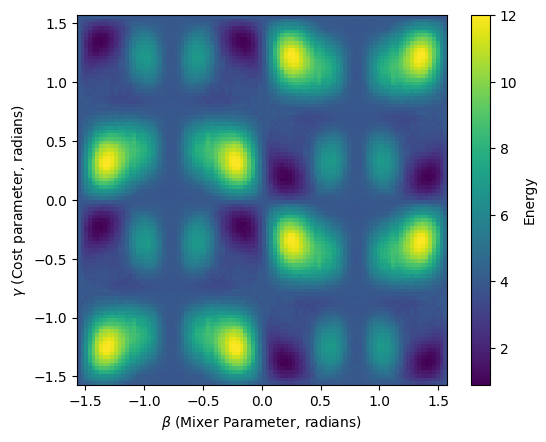

In [12]:
#type(EN)
#EN
plt.ylabel(r"$\gamma$ (Cost parameter, radians)")
plt.xlabel(r"$\beta$ (Mixer Parameter, radians)")
plt.imshow(EN1, #cmap = 'hot',
            extent=(beta_min, beta_max, gamma_min,gamma_max))
cbar=plt.colorbar()
cbar.set_label("Energy")
plt.show()
